# Code dependencies

Import all necessary packages.

In [ ]:
from google.colab import drive

import json
import time
import os

from os import path
from io import BytesIO
from base64 import b64decode
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.util
import librosa.display

from IPython.display import HTML, display, Audio, Javascript

!pip -q install pydub
from pydub import AudioSegment

import wave

import shutil

# Data files and directories

Mount the directory of personal Google Drive to Google Colab to enable permanent storage.

In [ ]:
# Mount directory of personal Google Drive to Google Colab to enable permanent storage.
drive.mount("/content/drive")
# Change NOTEBOOK_DIR depending on where you have saved this notebook.
NOTEBOOK_DIR = "/content/drive/MyDrive/"
# For example, the variable below stores the absolute file path to this notebook.
NOTEBOOK_FILEPATH = os.path.join(NOTEBOOK_DIR, "ASR_VS_HSR.ipynb")

Mounted at /content/drive


Locate the directory where all the test data files are stored.

In [ ]:
# Change TEST_DATA_DIR depending on how your test data folder is structured.
TEST_DATA_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT", "TIMIT", "TEST")
SOUND_FILES_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT-cut-sounds")
MAPPED_SOUND_FILES_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT-mapped-cut-sounds")

DF_FILEPATH = os.path.join(NOTEBOOK_DIR, "TIMIT-arpabets.csv")
SOUND_FILES_DF_FILEPATH = os.path.join(NOTEBOOK_DIR, "TIMIT-cut-sounds.csv")
SOUND_FILES_STATS_DF_FILEPATH = os.path.join(NOTEBOOK_DIR, "TIMIT-cut-sounds-stats.csv")
MAPPED_SOUND_FILES_DF_FILEPATH = os.path.join(NOTEBOOK_DIR, "TIMIT-mapped-cut-sounds.csv")

# Extract target phonemes

Locate all the target phonemes, and save their VCV structures and time metadata into a dataframe CSV file.

In [ ]:
target_arpabets = [
    "b",
    "p",
    "f",
    "th",
    "v",
    "n",
    "l",
    "m",
    "r",
    "f",
    "s",
    "z",
]

vowel_arpabets = [
    "aa",
    "ae",
    "ah",
    "ax-h",
    "ao",
    "aw",
    "ax",
    "axr",
    "ey",
    "eh",
    "er",
    "ey",
    "ih",
    "ix",
    "iy",
    "ow",
    "oy",
    "uh",
    "uw",
    "ux",
]

special_arpabets = [
    "bcl",
    "pcl",
]

In [ ]:
def is_valid_vcv_structure(phone_1, phone_2, phone_3, phone_4):
    if phone_2 in vowel_arpabets and phone_3 not in vowel_arpabets and phone_4 in vowel_arpabets:
        return True
    if phone_1 in vowel_arpabets and phone_2 in special_arpabets and phone_3 not in vowel_arpabets and phone_4 in vowel_arpabets:
        return True
    return False

def save_phn_test_data_to_df_file():
    df = pd.DataFrame(columns=[
        "filepath",
        "dialect_id",
        "speaker_id",
        "sentence_id",
        "start_time1",
        "start_time2",
        "start_time3",
        "start_time4",
        "end_time",
        "phone_1",
        "phone_2",
        "target_phone",
        "phone_4"
    ])

    for root, dirs, files in os.walk(TEST_DATA_DIR):
        # Scan through every file in TEST_DATA_DIR recursively.
        for name in files:
            filepath = os.path.join(root, name)
            # Only PHN files are relevant.
            # Do not include duplicate files (denoted by a trailing "(1)").
            duplicate = "(" in filepath and ")" in name
            if filepath[-3:] == "PHN" and not duplicate:
                with open(filepath, "r") as phn_file:
                    # Collect all lines in the file at once as a list of strs.
                    lines = phn_file.readlines()
                    for i, line in enumerate(lines):
                        # Remove any newline characters from the strs.
                        line_3 = line.replace("\n", "")
                        for target in target_arpabets:
                            # Only lines containing the target ARPAbet are relevant.
                            # The ARPAbet is the last value stored in each line.
                            if line_3.split(" ")[-1] == target:
                                # Remove any newline characters from the strs.
                                line_1 = lines[i - 2].replace("\n", "")
                                line_2 = lines[i - 1].replace("\n", "")
                                line_4 = lines[i + 1].replace("\n", "")
                                # Store the relevant data from each line into the dataframe.
                                phone_1 = line_1.split(" ")[2]
                                phone_2 = line_2.split(" ")[2]
                                phone_3 = line_3.split(" ")[2]
                                phone_4 = line_4.split(" ")[2]
                                if is_valid_vcv_structure(phone_1, phone_2, phone_3, phone_4):
                                    # Add a new row of data to the end of the dataframe.
                                    df.loc[len(df)] = {
                                        "filepath": filepath,
                                        "dialect_id": filepath.split("/")[-3],
                                        "speaker_id": filepath.split("/")[-2],
                                        "sentence_id": filepath.split("/")[-1].split(".")[0],
                                        "start_time1": line_1.split(" ")[0],
                                        "start_time2": line_2.split(" ")[0],
                                        "start_time3": line_3.split(" ")[0],
                                        "start_time4": line_4.split(" ")[0],
                                        "end_time": line_4.split(" ")[1],
                                        "phone_1": phone_1,
                                        "phone_2": phone_2,
                                        "target_phone": phone_3,
                                        "phone_4": phone_4,
                                    }

    # Preview some data in the dataframe.
    print(df)

    # Save the dataframe as a CSV file.
    print(f"DataFrame is being saved to file: {DF_FILEPATH}")
    df.to_csv(DF_FILEPATH)

Generating the phoneme dataframe file takes around 7 minutes to run on a Python 3 Google Compute Engine. Do not run if not necessary.

In [ ]:
# Run the function.
save_phn_test_data_to_df_file()

                                               filepath dialect_id speaker_id  \
0     /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR6/MR...        DR6      MRJR0   
1     /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR6/MR...        DR6      MRJR0   
2     /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR6/MR...        DR6      MRJR0   
3     /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR6/MR...        DR6      MRJR0   
4     /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR6/MR...        DR6      MRJR0   
...                                                 ...        ...        ...   
4480  /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR4/MT...        DR4      MTLS0   
4481  /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR4/MT...        DR4      MTLS0   
4482  /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR4/MT...        DR4      MTLS0   
4483  /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR4/MT...        DR4      MTLS0   
4484  /content/drive/MyDrive/TIMIT/TIMIT/TEST/DR4/MT...        DR4      MTLS0   

     sentence_id start_time

# Cut audio files into sound files

For each eligible VCV phoneme combination, cut their audio files into sound files.

In [ ]:
# import numpy as np

# This function takes an audio segment (1d array) as input, applies rise and fall
# at the beginning and end and returns the thus processed audio segment
# audio: 1d array
# fs: sampling frequency (sampling rate)
# duration: duration of the rise and fall in seconds

# def addRiseFall(audio,fs,duration = 0.005):
#   duration = int(duration * fs) # convert duration of rise and fall times from seconds to samples
#   d        = len(audio) # duration of the whole audio signal in samples
#   weight   = np.arange(duration) / duration # linear rise and fall times
#   w        = np.hanning(duration*2) # more frequently used Hann window
#   weight   = w[:duration]
#   audio[:duration]  = audio[:duration] * weight
#   audio[-duration:] = audio[-duration:] * np.flip(weight)
#   return audio

# audio = example_audio[int(0.5*sample_rate):int(0.6*sample_rate)] # for the example, cut 100 ms of the wave file, then apply 25-ms long rise and fall times
# audio = addRiseFall(audio, sample_rate,duration = 0.025)
# plot_audio(audio, sample_rate)
# plt.show()

Cutting audio files takes around 7 minutes to run on a Python 3 Google Compute Engine. Do not run if not necessary.

In [ ]:
# Assume that previous cells have been run before and the dataframe exists.
# Read the saved PHN test data file.
df = pd.read_csv(DF_FILEPATH)

if not os.path.exists(SOUND_FILES_DIR):
    # Create the SOUND_FILES_DIR directory if it doesn't already exist.
    # Otherwise, this will trigger a directory-not-found exception below.
    os.makedirs(SOUND_FILES_DIR)
else:
    raise Exception(f"SOUND_FILES_DIR already exists: {SOUND_FILES_DIR}")

sound_files_stats_df = pd.DataFrame(columns=["target_phone", "file_count"])
sound_files_df = pd.DataFrame(columns=["filepath","target_phone"])

# Keep track of how many files there are for each target phoneme.
file_count_dict = {}

# Keep track of the latest unique ID that has been assigned.
sound_unique_id_counter = 0
sound_unique_id_padding = 5
# See https://research.google.com/colaboratory/faq.html#drive-quota.
max_sound_unique_id = 20000

for index, row in list(df.iterrows()):
    vcv_audio_duration = (row["end_time"] - row["start_time2"]) / 16000 * 1000
    vc_audio_duration = (row["start_time4"] - row["start_time2"]) / 16000 * 1000
    cv_audio_duration = (row["end_time"] - row["start_time3"]) / 16000 * 1000

    if vcv_audio_duration >= 200:
        audio_filepath = row["filepath"].replace("PHN", "WAV")
        sound = AudioSegment.from_wav(audio_filepath)

        for cut_duration in [25, 50, 100, 200]:
            if cut_duration == 25:
                sound = sound + 6
            if cut_duration == 50:
                sound = sound + 3

            if cv_audio_duration >= cut_duration:
                startTime = row["start_time3"] / 16000 * 1000
                endTime = startTime + cut_duration
            else:
                endTime = row["end_time"] / 16000 * 1000
                startTime = endTime - cut_duration

            # Cut the audio file by the desired amount.
            extract = sound[startTime:endTime]
            extract = extract.fade_in(5).fade_out(5)

            target_phone_dir = os.path.join(
                SOUND_FILES_DIR,
                row["target_phone"]
            )
            if not os.path.exists(target_phone_dir):
                # Create the target phoneme directory if it doesn't already exist.
                # Otherwise, this will trigger a directory-not-found exception below.
                os.makedirs(target_phone_dir)

            # Save the cut sound file in SOUND_FILES_DIR.
            sound_unique_id_counter += 1
            if sound_unique_id_counter > max_sound_unique_id:
                break

            unique_id = str(sound_unique_id_counter).zfill(sound_unique_id_padding)
            sound_filepath = os.path.join(target_phone_dir,
                f"{unique_id}_{row['dialect_id']}_{row['speaker_id']}_{row['sentence_id']}_{row['phone_1']}_{row['phone_2']}_{row['target_phone']}_{row['phone_4']}_{cut_duration}.WAV"
            )
            extract.export(
                sound_filepath,
                format="wav"
            )

            sound_files_df.loc[len(sound_files_df)] = {
                "filepath": sound_filepath,
                "target_phone": row["target_phone"],
            }


            if row["target_phone"] not in file_count_dict:
                file_count_dict[row["target_phone"]] =  1
            else:
                file_count_dict[row["target_phone"]] += 1


for target_phone, file_count in file_count_dict.items():
    # Add a new row of data to the end of the dataframe.
    sound_files_stats_df.loc[len(sound_files_stats_df)] = {
        "target_phone": target_phone,
        "file_count": file_count,
    }

sound_files_stats_df.to_csv(SOUND_FILES_STATS_DF_FILEPATH, index=False)
sound_files_df.to_csv(SOUND_FILES_DF_FILEPATH, index=False)

# Preview some data in the dataframe.
print(sound_files_stats_df)
print(sound_files_df)

   target_phone  file_count
0             f        1912
1             s        1988
2             l        2228
3             p         496
4             r        2096
5             n        1464
6             v         728
7             m        1156
8             z         936
9            th         224
10            b         384
                                                filepath target_phone
0      /content/drive/MyDrive/TIMIT-cut-sounds/f/0000...            f
1      /content/drive/MyDrive/TIMIT-cut-sounds/f/0000...            f
2      /content/drive/MyDrive/TIMIT-cut-sounds/f/0000...            f
3      /content/drive/MyDrive/TIMIT-cut-sounds/f/0000...            f
4      /content/drive/MyDrive/TIMIT-cut-sounds/f/0000...            f
...                                                  ...          ...
13607  /content/drive/MyDrive/TIMIT-cut-sounds/l/1360...            l
13608  /content/drive/MyDrive/TIMIT-cut-sounds/s/1360...            s
13609  /content/drive/MyDrive/TIMI

Choose some sample sound files and plot their sound waves.

In [ ]:
def plot_cut_sound_wave(filename):
    spf = wave.open(filename, "r")

    signal = spf.readframes(-1)
    signal = np.fromstring(signal, "int16")

    if spf.getnchannels() == 2:
        raise Exception(f"Only mono-channel audio files are supported: {filename}")

    plt.figure(1, figsize=(5, 3))
    plt.title(filename)
    plt.plot(signal)
    plt.show()

<ipython-input-14-e17fdf1bd10b>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, "int16")


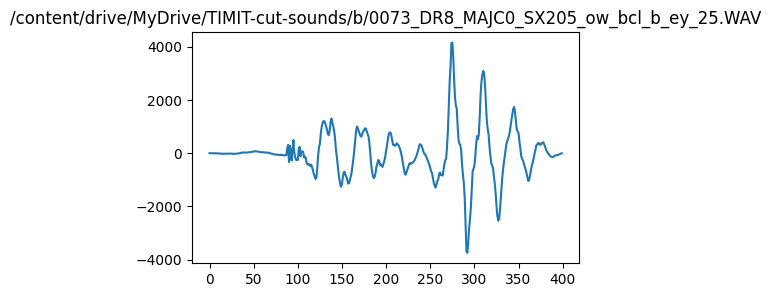

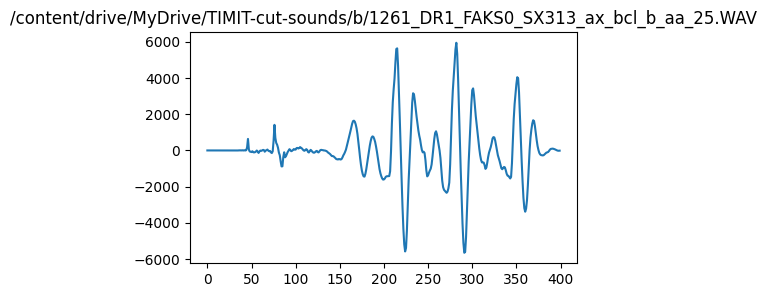

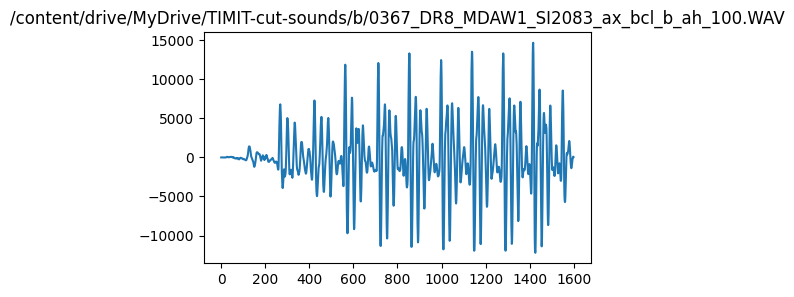

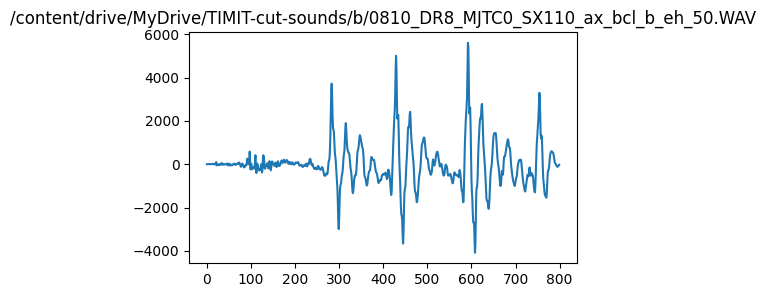

In [ ]:
# FIXME: Only sample files belonging to the same target phoneme are allowed.
sample_sound_filenames = [
    "0073_DR8_MAJC0_SX205_ow_bcl_b_ey_25.WAV",
    "1261_DR1_FAKS0_SX313_ax_bcl_b_aa_25.WAV",
    "0367_DR8_MDAW1_SI2083_ax_bcl_b_ah_100.WAV",
    "0810_DR8_MJTC0_SX110_ax_bcl_b_eh_50.WAV",
]
sample_phone = "b"

for sample_sound_filename in sample_sound_filenames:
    plot_cut_sound_wave(os.path.join(SOUND_FILES_DIR, sample_phone, sample_sound_filename))

# Map and filter sound files

Create a script to keep a map between test audios and its original naming.

Mapping sound files takes around 9 minutes to run on a Python 3 Google Compute Engine. Do not run if not necessary.

In [ ]:
# Assume that previous cells have been run before and the dataframe exists.
sound_files_df = pd.read_csv(SOUND_FILES_DF_FILEPATH)

if not os.path.exists(MAPPED_SOUND_FILES_DIR):
    # Create the MAPPED_SOUND_FILES_DIR directory if it doesn't already exist.
    # Otherwise, this will trigger a directory-not-found exception below.
    os.makedirs(MAPPED_SOUND_FILES_DIR)
else:
    raise Exception(f"MAPPED_SOUND_FILES_DIR already exists: {MAPPED_SOUND_FILES_DIR}")

mapped_sound_files_df = pd.DataFrame(columns=[
    "new_filepath",
    "old_filepath",
    "target_phone"
])

# Remove any rows that do not correspond to the desired target phonemes.
target_phones = ["b", "p", "m", "n", "l", "v"]

# FIXME: Assumes dataframe rows have already been grouped by long ID,
# i.e. dialect ID + speaker ID + sentence ID.
curr_long_ids = {}
long_id_counters = {}
max_long_id_counter = 96
long_id_number_padding = 4
for target_phone in target_phones:
    curr_long_ids[target_phone] = ""
    long_id_counters[target_phone] = 0

for index, row in list(sound_files_df.iterrows()):
    filepath = row["filepath"]
    target_phone = row["target_phone"]
    if target_phone in target_phones:
        # This target_phone is one that we want.
        filepath_parts = filepath.split("_")
        long_id = "_".join(filepath_parts[-8:-1])
        cut_duration = filepath_parts[-1].replace(".WAV", "")

        # Generate the new file name for the duplicate of this sound file.
        if long_id != curr_long_ids[target_phone]:
            curr_long_ids[target_phone] = long_id
            long_id_counters[target_phone] += 1
        long_id_number = long_id_counters[target_phone]

        # Limit the number of sound files copied because of data processing speed problems with Google Drive.
        if long_id_number <= max_long_id_counter:
            long_id_number = str(long_id_number).zfill(long_id_number_padding)
            new_filepath = os.path.join(
                MAPPED_SOUND_FILES_DIR,
                f"{target_phone}_{long_id_number}_{cut_duration}.WAV"
            )

            # Duplicate the sound file to a new destination.
            shutil.copy(filepath, new_filepath)

            # Add a new row of data to the end of the dataframe.
            mapped_sound_files_df.loc[len(mapped_sound_files_df)] = {
                "new_filepath": new_filepath,
                "old_filepath": filepath,
                "target_phone": target_phone
            }

mapped_sound_files_df.to_csv(MAPPED_SOUND_FILES_DF_FILEPATH, index=False)

# Preview some data in the dataframe.
print(mapped_sound_files_df)

                                           new_filepath  \
0     /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
1     /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
2     /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
3     /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
4     /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
...                                                 ...   
2299  /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
2300  /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
2301  /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
2302  /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   
2303  /content/drive/MyDrive/TIMIT-mapped-cut-sounds...   

                                           old_filepath target_phone  
0     /content/drive/MyDrive/TIMIT-cut-sounds/l/0001...            l  
1     /content/drive/MyDrive/TIMIT-cut-sounds/l/0001...            l  
2     /content/drive/MyDrive/TIMIT-cut-sounds/l/0001...            l  
3     /

TODO: Commented code for reference only.

In [ ]:
# for index, row in list(sound_files_df.iterrows()):
#     filepath = row["filepath"]
#     target_phone = row["target_phone"]
#     if target_phone in ["b", "p", "m", "n", "l", "v"]:
#         # This target_phone is one that we want.
#         filepath_parts = filepath.split("_")
#         long_id = "_".join(filepath_parts[-8:-5])
#         cut_duration = filepath_parts[-1].replace(".WAV", "")

#         # Generate the new file name for the duplicate of this sound file.
#         long_id_number = long_id_dict[long_id]
#         long_id_number = str(long_id_number).zfill(4)
#         new_filepath = os.path.join(
#             "/content/drive/MyDrive/",
#             f"{target_phone}_{cut_duration}_{long_id_number}.WAV"
#         )

#         if os.path.exists(new_filepath):
#             os.remove(new_filepath)

In [ ]:
# # Change this depending on how your data folder is structured.
# TEST_DATA_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT", "TIMIT", "TEST")
# print("SA1:")
# audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")
# Audio(os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV"))


# audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")

# #importing file from location by giving its path
# sound = AudioSegment.from_wav(audio)
# #Selecting Portion we want to cut
# StrtMin = 0
# StrtSec = 1.523
# EndMin = 0
# EndSec = 1.548
# # Time to milliseconds conversion
# StrtTime = StrtMin*60*1000+StrtSec*1000
# EndTime = StrtMin*60*1000+EndSec*1000
# # Opening file and extracting portion of it
# extract = sound[StrtTime:EndTime]
# # Saving file in required location
# extract.export(os.path.join(NOTEBOOK_DIR,"iysiy_25.WAV"), format="wav")
# # new file portion.mp3 is saved at required location

# Audio(os.path.join(NOTEBOOK_DIR,"iysiy_25.WAV"))

# **Task 2: Audio Trimming (Manual)**

Cut Sample Audio from all targeted phones to certain durations: 20, 50, 100 and 200 ms

**S from iy_s_iy (DR3_FKMS0_SA1)**

In [ ]:
# Change this depending on how your data folder is structured.
TEST_DATA_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT", "TIMIT", "TEST")
print("SA1:")
audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")
Audio(os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV"))


## **25ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.523
EndMin = 0
EndSec = 1.548
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"iysiy_25.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"iysiy_25.WAV"))

## **50ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.523
EndMin = 0
EndSec = 1.573
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"iysiy_50.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"iysiy_50.WAV"))

## **100ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.523
EndMin = 0
EndSec = 1.623
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"iysiy_100.WAV"), format="wav")
# new file portion.mp3 is saved at required location

NameError: ignored

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"iysiy_100.WAV"))

## **200ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","FKMS0","SA1.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.470
EndMin = 0
EndSec = 1.670
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"iysiy_200.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"iysiy_200.WAV"))

**b from aa_bcl_b_ix** (DR3_MLNT0_SX12)



In [ ]:
# Change this depending on how your data folder is structured.
TEST_DATA_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT", "TIMIT", "TEST")
print("SX12:")
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SX12.WAV")
Audio(os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SX12.WAV"))

## **25ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SX12.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 0.7313
EndMin = 0
EndSec = 0.7563
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"aabclbix_25.WAV"), format="wav")
# new file portion.mp3 is saved at required location

NameError: ignored

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"aabclbix_25.WAV"))

NameError: ignored

## **50ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SX12.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 0.6628
EndMin = 0
EndSec = 0.7128
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"aabclbix_50.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"aabclbix_50.WAV"))

## **100ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SX12.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 0.6628
EndMin = 0
EndSec = 0.7628
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"aabclbix_100.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"aabclbix_100.WAV"))

## **200ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SX12.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 0.5563
EndMin = 0
EndSec = 0.7563
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"aabclbix_200.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"aabclbix_200.WAV"))

## **r from ix_r_aw** (DR3_MLNT0_SI1547)

In [ ]:
# Change this depending on how your data folder is structured.
TEST_DATA_DIR = os.path.join(NOTEBOOK_DIR, "TIMIT", "TIMIT", "TEST")
print("SI1574:")
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SI1574.WAV")
Audio(os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SI1574.WAV"))

## **25ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SI1574.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.0325
EndMin = 0
EndSec = 1.0530
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
sound = sound + 20 #louder by Xdb
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"ix_r_aw_25.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"ix_r_aw_25.WAV"))

## **50ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SI1574.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.027
EndMin = 0
EndSec = 1.077
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"ix_r_aw_50.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"ix_r_aw_50.WAV"))

## **100ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SI1574.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 1.002
EndMin = 0
EndSec = 1.102
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"ix_r_aw_100.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"ix_r_aw_100.WAV"))

## **200ms**

In [ ]:
audio = os.path.join(TEST_DATA_DIR, "DR3","MLNT0","SI1574.WAV")

#importing file from location by giving its path
sound = AudioSegment.from_wav(audio)
#Selecting Portion we want to cut
StrtMin = 0
StrtSec = 0.952
EndMin = 0
EndSec = 1.152
# Time to milliseconds conversion
StrtTime = StrtMin*60*1000+StrtSec*1000
EndTime = StrtMin*60*1000+EndSec*1000
# Opening file and extracting portion of it
extract = sound[StrtTime:EndTime]
# Saving file in required location
extract.export(os.path.join(NOTEBOOK_DIR,"ix_r_aw_200.WAV"), format="wav")
# new file portion.mp3 is saved at required location

In [ ]:
Audio(os.path.join(NOTEBOOK_DIR,"ix_r_aw_200.WAV"))